# Ultimate Challenge Notebook
## Part 1 Exploratory Data Analysis


### Table of Contents
- [Transforming The Login Data Into 15-Minute Bins](#Transforming-The-Login-Data-Into-15-Minute-Bins)
- [Part 1 Exploratory data analysis](#Part-1-Exploratory-data-analysis)
  - [Visualizing Binned Login Data](#Visualizing-Binned-Login-Data)
  - [Observations](#Observations)
- [Part 2 Experiment and metrics design](#Part-2-Experiment-and-metrics-design)
  - [Measuring Success](#Measuring-Success)
  - [Practical Experiment](#Practical-Experiment)
- [Part 3 Predictive Modeling](#Part-3-Predictive-Modeling)


Part 1 Exploratory data analysis
### Transforming The Login Data Into 15-Minute Bins


In [1]:
# __Environment__
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cd_data = 'data/'
cd_figures = 'figures/'

# __Custom_Functions__
if __name__ == '__main__':
    from library import *


In [2]:
# __Load_and_Prepare_Data__
logins_df = import_logins(cd_data+'logins.json')
logins_to_time = pd.to_datetime(logins_df['login_time'])
logins_df_batched = batch_data(logins_to_time)


Batch Size:  9314 
Batches:  10 
Original:  93142


In [3]:
# __Processing_Data__
batch_engine = process_batch(logins_df_batched, bin_datetimes)

stage_processed_data = []
for batch in tqdm(batch_engine):
    stage_processed_data.append(batch)

logins = pd.concat(stage_processed_data)
logins.to_csv(cd_data+'logins_binned.csv', index=False)

10it [00:10,  1.06s/it]


### Visualizing Binned Login Data


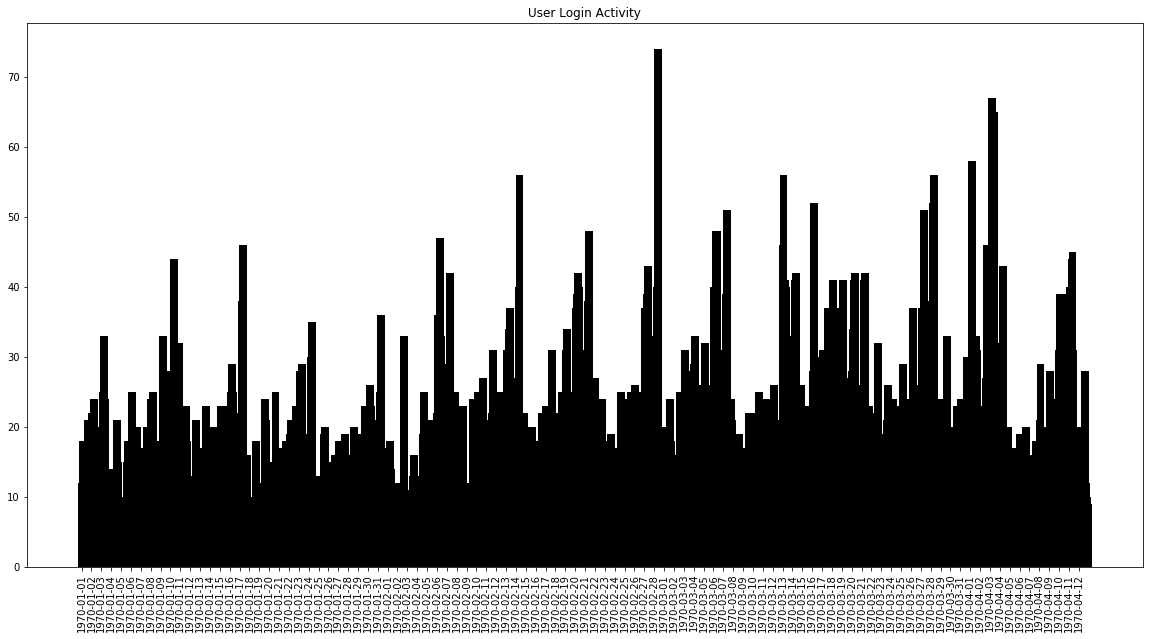

In [4]:
# __Data_Visualization__
plot_bins(logins, path=cd_figures)


### Observations
The data shows that there are trends every seven days where user activity spikes. During the week the login activity sharply moves downward. There is also slight seasonal activity showing an overall ebb peaking on March 1st. This trend suggests predictability and is a good candidate for using machine learning.


## Part 2 Experiment and metrics design

### Measuring Success
The measure of success for this experiment could be both location vs local driver data and the number of tolls reimbursed. If tolls reimbursed and drivers left their local city for pickups and drop-offs by measurable amount x, then the experiment would be a success. If driver's stay in the same local routes and do not get reimbursed for tolls, then other factors are keeping the drivers from moving cities.

A secondary factor to keep in mind during the experiment is if the pilot program for toll reimbursement is generating more net income after reimbursing the tolls. If net income dips below current metrics the pilot toll reimbursement program would be a failure.
*x would be defined after analyzing current driver data.*


### Practical Experiment
There will two populations in our experiment, the control population and the pilot population.
- Test variables are: [Location vs Local activity, Toll reimbursements, Driver commission, revenue generated, When Active]
- The control population will be randomly selected drivers currently in the system that is not in the pilot population.
- The pilot population will be randomly selected drivers that are not in the control population and will get to use the new feature of toll reimbursement.
- After one month of gathering data on the population we can analyze the test variables against the pilot variables and assess to launch toll reimbursement, cancel toll reimbursement, or continue the experiment.
> Testing would involve finding which variables attribute to a higher net income and predicting that income using the entire driver population. The model to use for prediction would be trained on the pilot population data.
*I wouldn't want to commit to a specific model or test at this time until several different variations have been tried and tested for accuracy.*
Experiment results will be documented in an easy-to-read news-article format explaining how well the pilot drivers adopted the program, and the difference in income generated between both populations. The article will include a explanation of the experiment and visualizations on key metrics. A presentation will be prepared for those who have been briefed with the article to go over questions and deliver recommendations.


## Part 3 ‐ Predictive Modeling


In [5]:
# __Data_Cleaning__
rider_df = pd.read_json(cd_data+'ultimate_data_challenge.json')

# Replacing the Nan values with the mean in the avg_rating_by_driver columns
rider_df['avg_rating_by_driver'].fillna(np.mean(rider_df['avg_rating_by_driver']), inplace=True)

# Replacing the missing driver ratings with the mean.
rider_df['avg_rating_of_driver'].fillna(np.mean(rider_df['avg_rating_of_driver']), inplace=True)

# Dropping all observations without a phone type.
rider_df.dropna(inplace=True)

# One-hot encoding of the city and phone columns
rider_encoded_df = one_hot(rider_df, ['city', 'phone', 'ultimate_black_user'])

# Changing datetimes from strings to datetimes.
datetime_strings = ['signup_date', 'last_trip_date']

rider_encoded_df['signup_date'] = pd.to_datetime(rider_encoded_df['signup_date'])
rider_encoded_df['last_trip_date'] = pd.to_datetime(rider_encoded_df['last_trip_date'])

# Aliasing the dataframe for exploration
re_df = rider_encoded_df
# Remving outliers
re_df[re_df['trips_in_first_30_days'] >= re_df['trips_in_first_30_days'].std()*3] = np.mean(re_df['trips_in_first_30_days'])

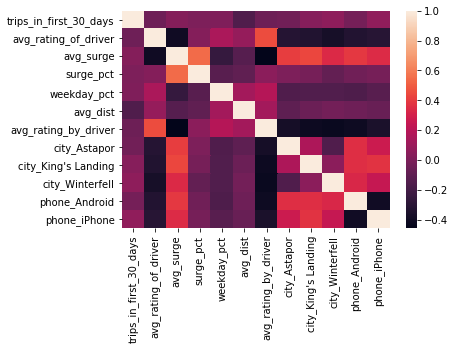

In [6]:
sns.heatmap(rider_encoded_df.corr())

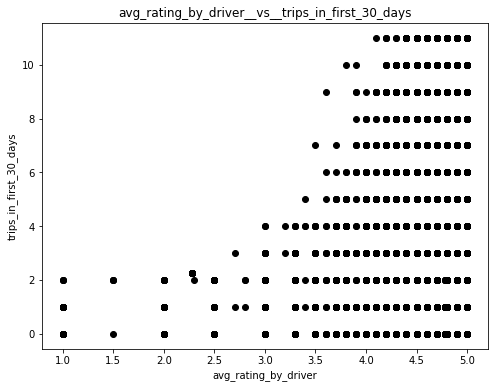

In [7]:
plt.figure(figsize=(8,6))
plt.title('avg_rating_by_driver'+'__vs__'+'trips_in_first_30_days')
plt.scatter(re_df['avg_rating_by_driver'], re_df['trips_in_first_30_days'], color='black')
plt.xlabel('avg_rating_by_driver')
plt.ylabel('trips_in_first_30_days')
plt.savefig(cd_figures+'ratings_vs_trips.png', transparent=True)


In [8]:
num_users = len(re_df['signup_date'])
active_users = re_df[re_df['trips_in_first_30_days'] > 0]['trips_in_first_30_days'].sum()
retention_of_users = num_users/active_users
print('The retention of users after the first 30 days is {0}%'.format(round(retention_of_users*100, 2), '%'))


The retention of users after the first 30 days is 55.41%


In [9]:
# plt.figure(figsize=(8,6))
# title = x.name + ' vs ' + y.name
# plt.title(title.title())
# x = re_df['avg_dist']
# y = re_df['trips_in_first_30_days']
# plt.scatter(y, x)
# plt.xlabel(x.name)
# plt.ylabel(y.name)
# plt.save_fig(cd_figures+title.replace(' ', '_')+'.png')
#
# series_list = []
# for column in re_df.columns.to_list():
#     series_list.append(re_df[column])
"""Commenting out to increase runtime speed when restarting kernel"""
# plt.figure(figsize=(40,35))
# sns.pairplot(re_df)
# plt.savefig(cd_figures+'pairplot.png', transparent=True)

'Commenting out to increase runtime speed when restarting kernel'

### Observations
There are not any apparent correlations with the a positive trip in the next 30 days.
However, there is a positive trend with avg_rating_by_driver and an active user and there is a negative trend with avg_surge and an active user.
This suggests that participation and availability increases user activity.
**Unfortunately the trend with avg_rating_by_driver is almost worthless because that data can only be generated by an active user.**
So let's plan to reduce the avg_surge to increase user retention.
Another way to look at this, is to add more drivers which will increase availability and rider user retention.


### Part 3 Predictive Modeling
Unfortunately, this data is not good for prediction.
There are not any strong correlations that are practical cause and affects of user retention and further experiments must be done before attempting to predict active users. We can measure participation, but this an effect of activity and does not cause user activity.

Ultimate should run A/B tests and pilot projects to search for factors that correlate to user retention.
Possible pilots include:
- Rider miles: where active users earn miles the more they use the service.
- Subscription options: Users will pay a subscription fee instead of paying for each ride.
- Partnering with large events: Allowing venues to pay for Ultimate drivers as a shuttle service instead of users.